In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch
import PIL

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
import numpy as np
from PIL import Image

# DATASET_PATH = '/kaggle/input/dog-emotion/Dog Emotion/'
DATASET_PATH = '/content/drive/MyDrive/Dog_Emotion_1/'

data = {'img': [], 'emotion': []}

for emotion in ['angry', 'happy', 'relaxed', 'sad']:
    for dirname, _, filenames in os.walk(DATASET_PATH + emotion + '/'):
        for filename in filenames:
            data['img'].append(os.path.join(dirname, filename))
            data['emotion'].append(emotion)

df = pd.DataFrame.from_dict(data)

In [ ]:
# import numpy as np
# from PIL import Image

# DATASET_PATH = '/kaggle/input/dog-emotion/Dog Emotion/'

# data = {'img': [], 'emotion': []}

# for emotion in ['angry', 'happy', 'relaxed', 'sad']:
#     for dirname, _, filenames in os.walk(DATASET_PATH + emotion + '/'):
#         for filename in filenames:
#             data['img'].append(os.path.join(dirname, filename))
#             data['emotion'].append(emotion)

# df = pd.DataFrame.from_dict(data)

In [52]:
df

,img,emotion
0,/content/drive/MyDrive/Dog_Emotion_1/angry/0Av...,angry
1,/content/drive/MyDrive/Dog_Emotion_1/angry/0C5...,angry
2,/content/drive/MyDrive/Dog_Emotion_1/angry/09d...,angry
3,/content/drive/MyDrive/Dog_Emotion_1/angry/0TS...,angry
4,/content/drive/MyDrive/Dog_Emotion_1/angry/0aN...,angry
...,...,...
4005,/content/drive/MyDrive/Dog_Emotion_1/sad/zvgEE...,sad
4006,/content/drive/MyDrive/Dog_Emotion_1/sad/ztwzd...,sad
4007,/content/drive/MyDrive/Dog_Emotion_1/sad/zmAi6...,sad
4008,/content/drive/MyDrive/Dog_Emotion_1/sad/zq3lf...,sad


In [53]:
emotion_labels_map = {}

unique_emotions = df['emotion'].unique()
for i in range(len(unique_emotions)):
    emotion_labels_map[unique_emotions[i]] = i

In [54]:
df['emotion_label'] = df['emotion'].apply(lambda x: emotion_labels_map[x])
df

,img,emotion,emotion_label
0,/content/drive/MyDrive/Dog_Emotion_1/angry/0Av...,angry,0
1,/content/drive/MyDrive/Dog_Emotion_1/angry/0C5...,angry,0
2,/content/drive/MyDrive/Dog_Emotion_1/angry/09d...,angry,0
3,/content/drive/MyDrive/Dog_Emotion_1/angry/0TS...,angry,0
4,/content/drive/MyDrive/Dog_Emotion_1/angry/0aN...,angry,0
...,...,...,...
4005,/content/drive/MyDrive/Dog_Emotion_1/sad/zvgEE...,sad,3
4006,/content/drive/MyDrive/Dog_Emotion_1/sad/ztwzd...,sad,3
4007,/content/drive/MyDrive/Dog_Emotion_1/sad/zmAi6...,sad,3
4008,/content/drive/MyDrive/Dog_Emotion_1/sad/zq3lf...,sad,3


In [55]:
from torch.utils.data import DataLoader, Dataset

class Dataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.data.loc[idx, "img"]).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(self.data.loc[idx, "emotion_label"])
        return image, label

In [56]:
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["img"], df["emotion_label"], random_state=42)

X_train.index = np.arange(len(X_train))
y_train.index = np.arange(len(y_train))
X_test.index = np.arange(len(X_test))
y_test.index = np.arange(len(y_test))

In [57]:
transform_train = transform_test = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(224),  # Random crop with resize to 224x224
    v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    v2.RandomRotation(7),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [58]:
train_ds = Dataset(pd.concat([X_train, y_train], axis=1), transform_train)
test_ds = Dataset(pd.concat([X_test, y_test], axis=1), transform_test)


In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, criterion, device, stage, current_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % 10 == 0:
            print(f'Stage [{stage}], Epoch [{current_epoch+1}/{total_epochs}], Step [{i+1}/{len(loader)}], '
                  f'Loss: Loss: {running_loss / (i+1):.4f}, '
                  f'Accuracy: {100 * correct/total:.2f}%')
            running_loss = 0.0

    return correct / total

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(true_labels, predictions)
    print(f'Validation Loss: {val_loss/len(loader):.4f}, Accuracy: {100*val_acc:.2f}%')
    return val_acc

In [67]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
model.heads.head = nn.Linear(in_features=768, out_features=4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [69]:
training_config = {
    'stages': {
        1: {'layers': ['head'], 'lr': 1e-4, 'epochs': 20, 'wd': 0.0},
        2: {'layers': [-1], 'lr': 1e-5, 'epochs': 15, 'wd': 9e-5},
        3: {'layers': [-2, -1], 'lr': 1e-6, 'epochs': 10, 'wd': 1e-4},
        4: {'layers': [-3, -2, -1], 'lr': 1e-7, 'epochs': 7, 'wd': 2e-4}
    }
}

In [70]:
for param in model.parameters():
    param.requires_grad = False

best_val_acc = 0.0
train_acc_history = []
val_acc_history = []

for stage, config in training_config['stages'].items():
    print(f"\nStage {stage}: Обучение слоев {config['layers']}")

    for layer in config['layers']:
        if layer == 'head':
            for param in model.heads.head.parameters():
                param.requires_grad = True
        else:
            for param in model.encoder.layers[layer].parameters():
                param.requires_grad = True

    params_to_optimize = []
    for layer in config['layers']:
        if layer == 'head':
            params_to_optimize.append({'params': model.heads.head.parameters(), 'lr': config['lr']})
        else:
            params_to_optimize.append({'params': model.encoder.layers[layer].parameters(),
                                     'lr': config['lr'] * (10 ** (layer + 3))})
    optimizer = optim.Adam(params_to_optimize, weight_decay=config['wd'])


    for epoch in range(config['epochs']):
        train_acc = train_epoch(model, train_loader, optimizer, criterion,
                               device, stage, epoch, config['epochs'])
        val_acc = validate(model, test_loader, criterion, device)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_stage{stage}.pth')

print("\nОбучение завершено!")
print(f"Best accuracy: {100*best_val_acc:.2f}%")


Stage 1: Обучение слоев ['head']
Stage [1], Epoch [1/20], Step [10/93], Loss: Loss: 1.4560, Accuracy: 23.12%
Stage [1], Epoch [1/20], Step [20/93], Loss: Loss: 0.7124, Accuracy: 23.91%
Stage [1], Epoch [1/20], Step [30/93], Loss: Loss: 0.4738, Accuracy: 24.48%
Stage [1], Epoch [1/20], Step [40/93], Loss: Loss: 0.3531, Accuracy: 24.69%
Stage [1], Epoch [1/20], Step [50/93], Loss: Loss: 0.2830, Accuracy: 25.50%
Stage [1], Epoch [1/20], Step [60/93], Loss: Loss: 0.2318, Accuracy: 25.52%
Stage [1], Epoch [1/20], Step [70/93], Loss: Loss: 0.1941, Accuracy: 26.29%
Stage [1], Epoch [1/20], Step [80/93], Loss: Loss: 0.1669, Accuracy: 27.50%
Stage [1], Epoch [1/20], Step [90/93], Loss: Loss: 0.1522, Accuracy: 27.99%
Validation Loss: 1.3219, Accuracy: 36.09%
Stage [1], Epoch [2/20], Step [10/93], Loss: Loss: 1.3211, Accuracy: 38.44%
Stage [1], Epoch [2/20], Step [20/93], Loss: Loss: 0.6516, Accuracy: 39.53%
Stage [1], Epoch [2/20], Step [30/93], Loss: Loss: 0.4414, Accuracy: 37.92%
Stage [1], E

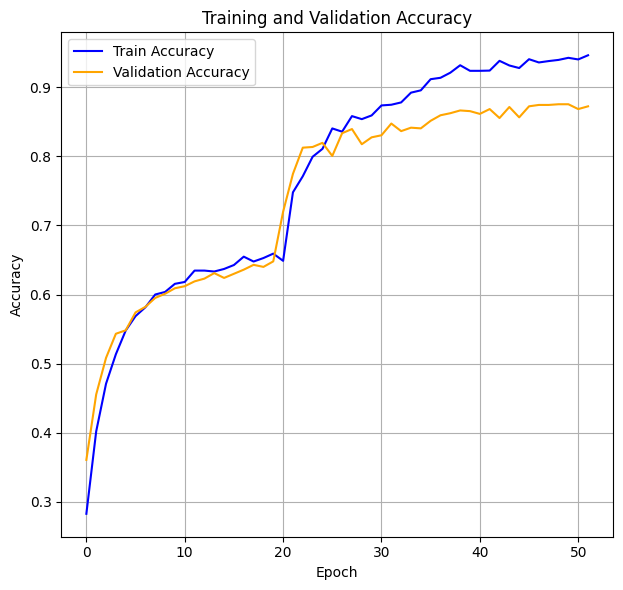

In [71]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()